In [130]:
import os
import requests
import pandas as pd

In [131]:
pip install tensorflow

In [132]:
# Make sure that you have all these libaries available to run the code successfully

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler


In [133]:

api_key = os.getenv('003TTYX9QZ1D1U6A')
base_url = 'https://www.alphavantage.co/query?'
params = {'function': 'TIME_SERIES_INTRADAY_EXTENDED',
           'symbol':'PHUN',
           'interval': '15min',
           'slice'   : 'year1month1',
           'adjusted':'True',
           'apikey': 'api_key'}

In [134]:
response = requests.get(base_url, params=params)

In [135]:
#Save CSV to file
with open('Phunware.csv','wb') as file:
     file.write(response.content)

In [136]:
df = pd.read_csv('Phunware.csv') #Create pandas dataframe

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    1339 non-null   object 
 1   open    1339 non-null   float64
 2   high    1339 non-null   float64
 3   low     1339 non-null   float64
 4   close   1339 non-null   float64
 5   volume  1339 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 62.9+ KB


In [138]:
df.head()

,time,open,high,low,close,volume
0,2021-03-17 20:00:00,2.25,2.26,2.21,2.26,14257
1,2021-03-17 19:45:00,2.25,2.26,2.25,2.26,2300
2,2021-03-17 19:30:00,2.25,2.25,2.23,2.23,4770
3,2021-03-17 19:15:00,2.27,2.27,2.26,2.26,3242
4,2021-03-17 19:00:00,2.25,2.25,2.25,2.25,9938


In [139]:
#Sort dataframe by date with the most recent date on top or at the beginning of the data set
df.sort_values(by=['time'])

,time,open,high,low,close,volume
1338,2021-02-16 04:15:00,2.81,2.93,2.81,2.88,9114
1337,2021-02-16 04:30:00,2.86,2.92,2.86,2.89,6505
1336,2021-02-16 04:45:00,2.89,2.92,2.89,2.91,3317
1335,2021-02-16 05:00:00,2.91,2.92,2.86,2.86,2783
1334,2021-02-16 05:15:00,2.87,2.93,2.87,2.89,3294
...,...,...,...,...,...,...
4,2021-03-17 19:00:00,2.25,2.25,2.25,2.25,9938
3,2021-03-17 19:15:00,2.27,2.27,2.26,2.26,3242
2,2021-03-17 19:30:00,2.25,2.25,2.23,2.23,4770
1,2021-03-17 19:45:00,2.25,2.26,2.25,2.26,2300


In [140]:
#Determine if any values is missing. a true response indicated missing value and a false response indicate there are no missing values
df.isnull().values.any()

False

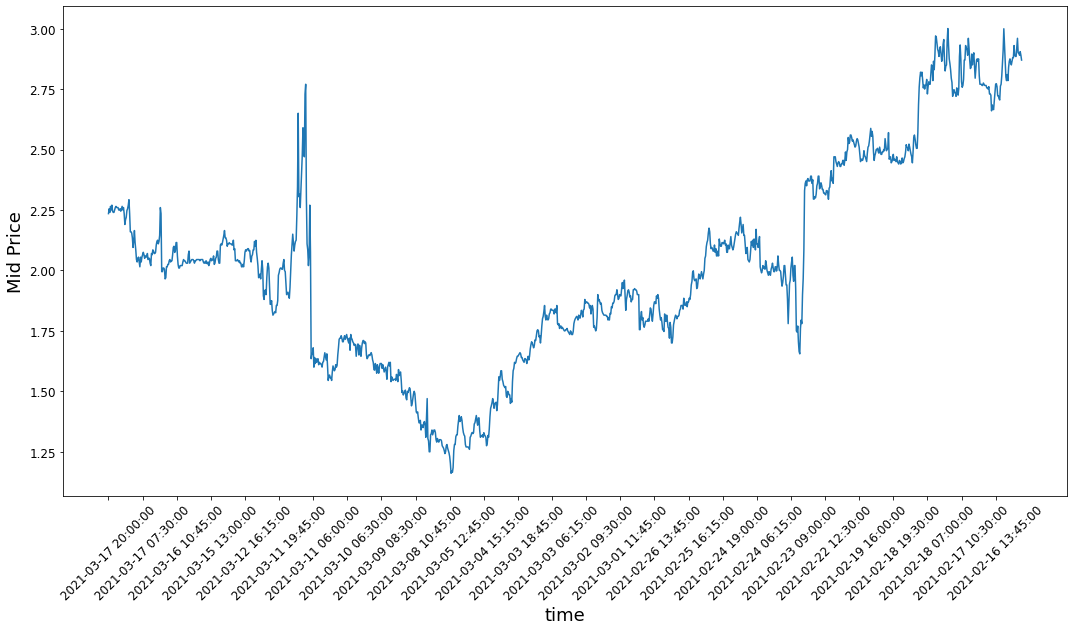

In [141]:
# Data visualization for mid price
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],50),df['time'].loc[::50],rotation=45)
plt.xlabel('time',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

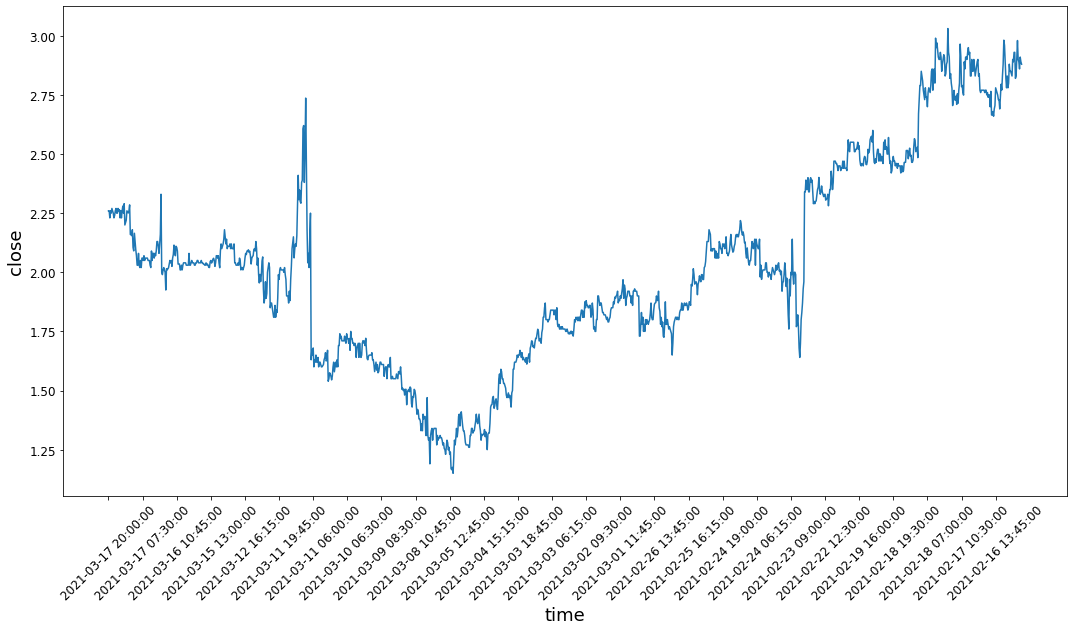

In [142]:
# Data visualization for close price
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['close']))
plt.xticks(range(0,df.shape[0],50),df['time'].loc[::50],rotation=45)
plt.xlabel('time',fontsize=18)
plt.ylabel('close',fontsize=18)
plt.show()

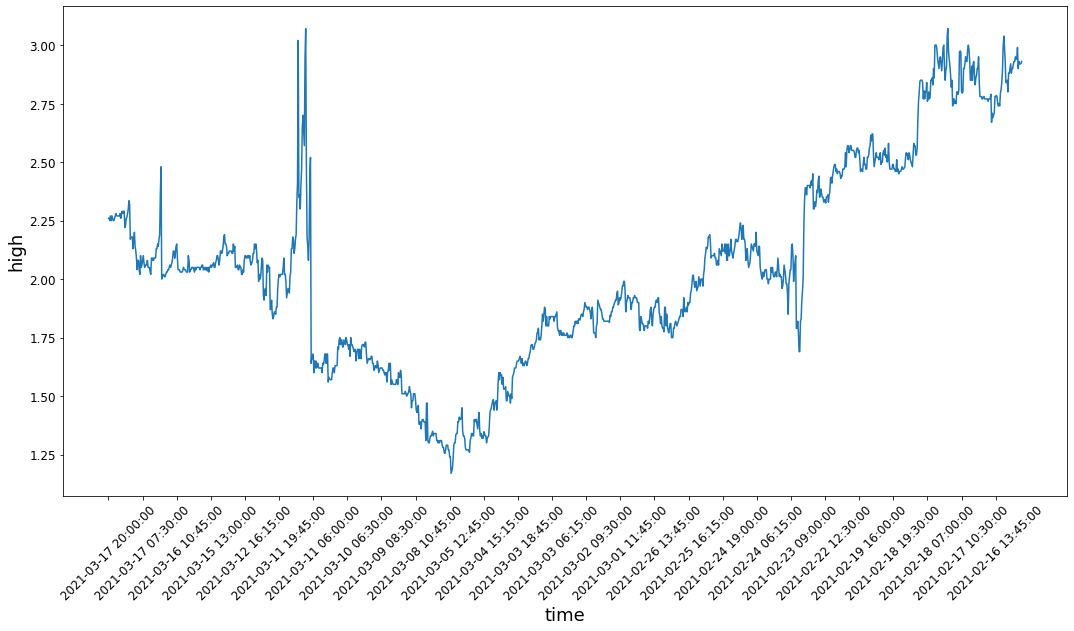

In [143]:
# Data visualization for high price
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['high']))
plt.xticks(range(0,df.shape[0],50),df['time'].loc[::50],rotation=45)
plt.xlabel('time',fontsize=18)
plt.ylabel('high',fontsize=18)
plt.show()

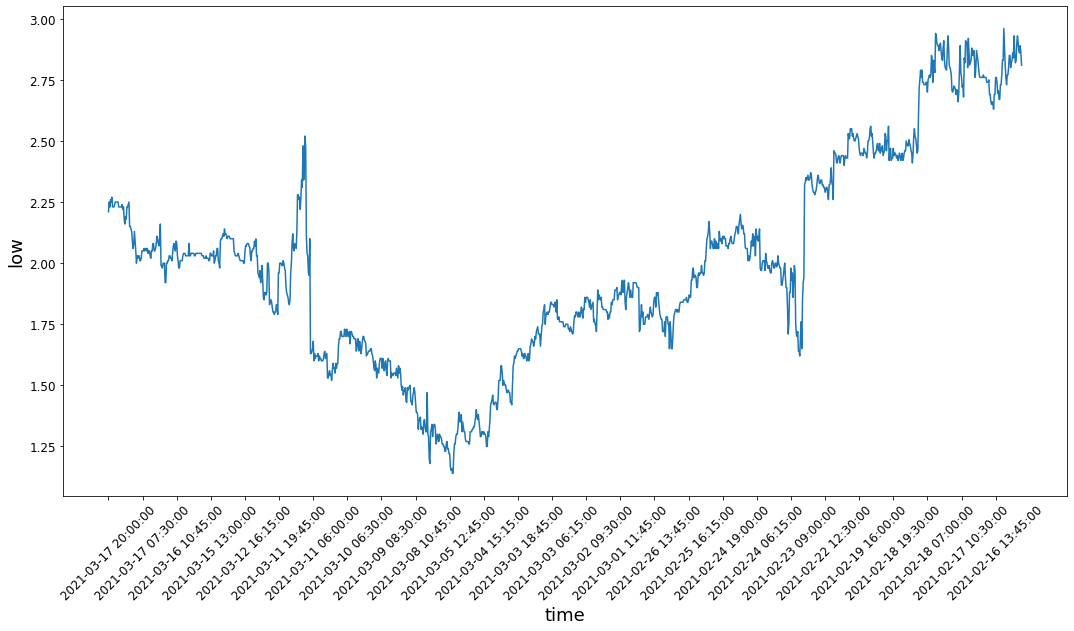

In [144]:
# Data visualization for low price
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']))
plt.xticks(range(0,df.shape[0],50),df['time'].loc[::50],rotation=45)
plt.xlabel('time',fontsize=18)
plt.ylabel('low',fontsize=18)
plt.show()

In [145]:
# Lets define close price
close_prices=df.loc[:,'close']


In [146]:
#split the training data & test data. The training data will be the first 1,000 data points of the time series and rest will be test data.
train_data = close_prices[:1000]
test_data = close_prices[1000:]

In [147]:
#Normalizing the data
#need to define a scaler to normalize the data. MinMaxScalar scales all the data to be in the region of 0 and 1. Also
#reshape the training and test data to be in the shape [data_size, num_features]
scaler = MinMaxScaler()
train_data = train_data.values.reshape(-1,1)
test_data = test_data.values.reshape(-1,1)


In [148]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 200
for di in range(0,800,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [149]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [150]:
# Now we perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(1000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [151]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        time = dt.datetime.strptime(k, '%Y-%m-%d').time() + dt.timedelta(days=1)
    else:
        time = df.loc[pred_idx,'time']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(time)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.02096


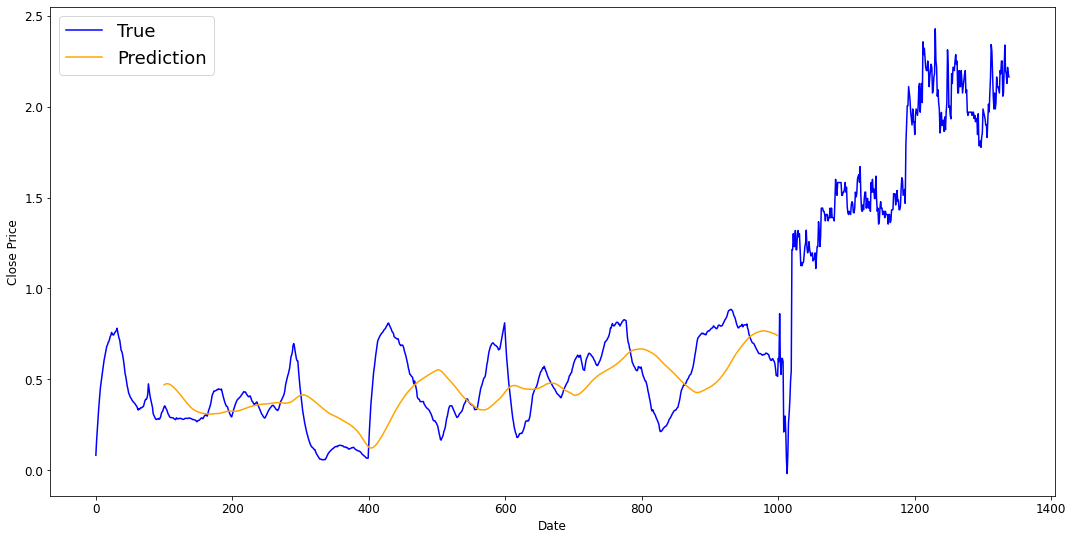

In [152]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()
#standard average model is not that good doesnt predict accurately the stock price. We can infer this stock to be unpredictable.

In [153]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(time)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00036


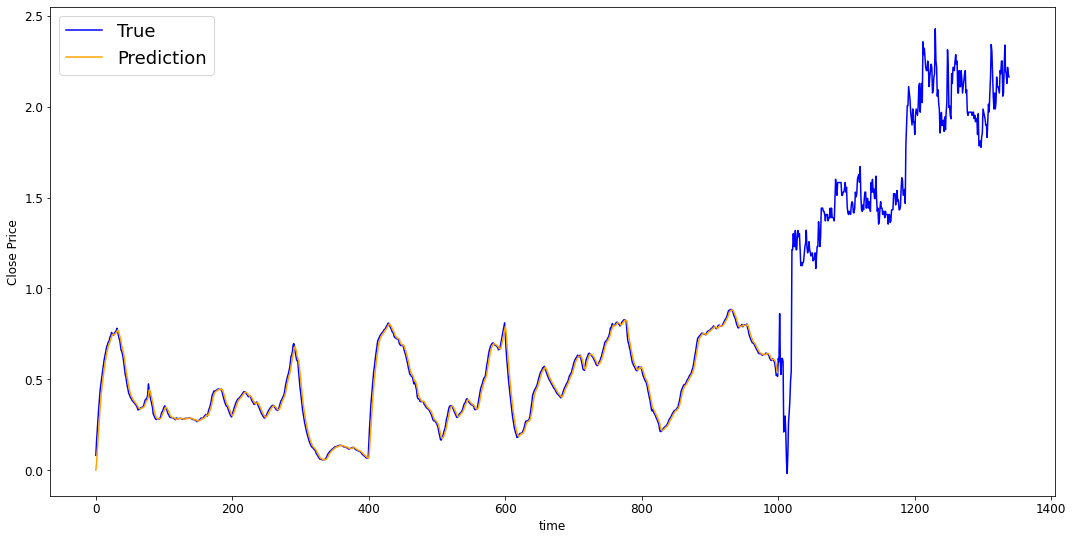

In [154]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('time')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()
#this exponential model is better than the standard average model it fits the line almost perfectly

In [163]:
training_set = df.iloc[:800, 3:4].values
test_set = df.iloc[800:, 3:4].values

In [164]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [167]:
pip install keras

In [169]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [170]:
model = Sequential()

In [171]:

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Train on 740 samples
Epoch 1/100
740/740 [==============================] - 2s 3ms/sample - loss: 0.0465
Epoch 2/100
740/740 [==============================] - 1s 2ms/sample - loss: 0.0108
Epoch 3/100
740/740 [==============================] - 1s 2ms/sample - loss: 0.0085
Epoch 4/100
740/740 [==============================] - 1s 2ms/sample - loss: 0.0093
Epoch 5/100
740/740 [==============================] - 1s 2ms/sample - loss: 0.0079
Epoch 6/100
740/740 [==============================] - 1s 2ms/sample - loss: 0.0097
Epoch 7/100
740/740 [==============================] - 1s 2ms/sample - loss: 0.0072
Epoch 8/100
740/740 [==============================] - 1s 2ms/sample - loss: 0.0071
Epoch 9/100
740/740 [==============================] - 1s 2ms/sample - loss: 0.0075
Epoch 10/100
740/740 [==============================] - 1s 2ms/sample - loss: 0.0061
Epoch 11/100
740/740 [==============================] - 1s 2ms/sample - loss: 0.0072
Epoch 12/100
740/740 [==============================]

In [212]:
# Getting the predicted stock price of 2021
dataset_train = df.iloc[:800, 3:4]
dataset_test = df.iloc[800:, 3:4]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(459, 60, 1)


In [213]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

ValueError: x and y must have same first dimension, but have shapes (539,) and (459, 1)

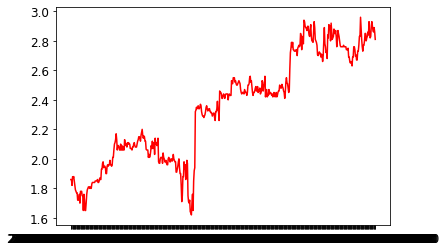

In [215]:
# Visualising the results
plt.plot(df.loc[800:, 'time'],dataset_test.values, color = 'red', label = 'Real Phunware Stock Price')
plt.plot(df.loc[800:, 'time'],predicted_stock_price, color = 'blue', label = 'Predicted Phunware Stock Price')
plt.xticks(np.arange([]))
plt.title('Phunware Stock Price Prediction')
plt.xlabel('time')
plt.ylabel('Phunware Stock Price')
plt.legend()
plt.show()